### UAS BENGKEL KODING - DATA SCIENCE
#### Prediksi Customer Churn dengan Machine Learning
Identitas:
- Nama  : ANGELICA WIDYASTUTI KOLO
- NIM   : A11.2021.13212
- Kelas : BENGKOD - DS01
- Dataset: Telco Customer Churn

### 1. IMPORT LIBRARY

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Library untuk handling imbalance data
from imblearn.over_sampling import SMOTE

### 2. LOAD DATASET

In [56]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [57]:
print(f"Dataset berhasil dimuat!")
print(f"Jumlah Baris: {df.shape[0]}")
print(f"Jumlah Kolom: {df.shape[1]}\n")

Dataset berhasil dimuat!
Jumlah Baris: 7043
Jumlah Kolom: 21



### 3. PREPROCESSING AWAL

In [58]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)
df.drop('customerID', axis=1, inplace=True)

/tmp/ipython-input-2878053356.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


### 4. PEMISAHAN FITUR DAN TARGET

In [59]:
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'Yes': 1, 'No': 0})

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

### 5. SPLIT DATA

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 6. PIPELINE PREPROCESSING

In [61]:
# Mengubah kategori menjadi angka (OneHot) dan standarisasi angka (Scaling)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ])

In [62]:
# Terapkan preprocessing pada data training
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [63]:
# Ambil nama fitur setelah encoding untuk Feature Importance nanti
feature_names = num_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols))

### 8. PENANGANAN IMBALANCE DATA (SMOTE)

Jumlah Churn sebelum SMOTE:
Churn
0    4139
1    1495
Name: count, dtype: int64

Jumlah Churn setelah SMOTE:
Churn
0    4139
1    4139
Name: count, dtype: int64


/tmp/ipython-input-2373372653.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='viridis')
/tmp/ipython-input-2373372653.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_balanced, palette='magma')


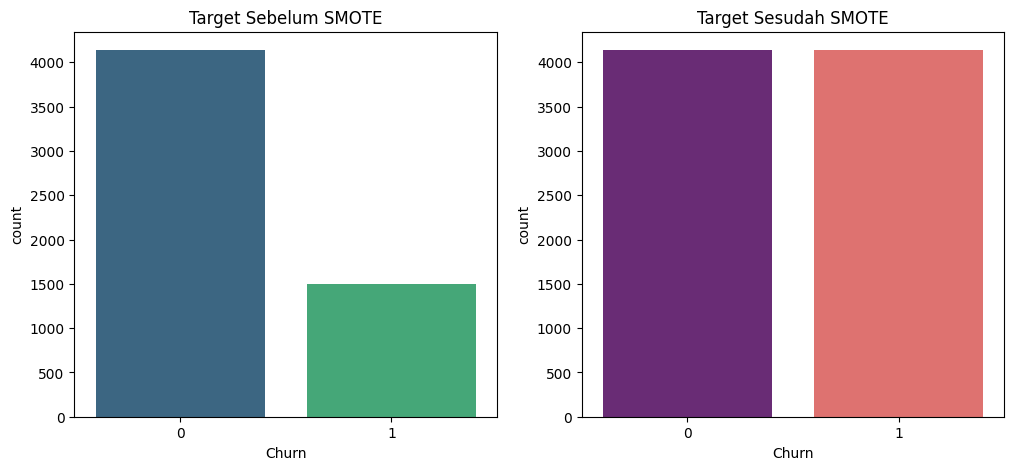

In [64]:
print(f"Jumlah Churn sebelum SMOTE:\n{y_train.value_counts()}")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_preprocessed, y_train)
print(f"\nJumlah Churn setelah SMOTE:\n{y_train_balanced.value_counts()}")

# Visualisasi SMOTE

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette='viridis')
plt.title('Target Sebelum SMOTE')
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_balanced, palette='magma')
plt.title('Target Sesudah SMOTE')
plt.show()

### 9. DEFINISI 3 MODEL

In [65]:
model_lr_direct = LogisticRegression(max_iter=1000, random_state=42)
model_rf_direct = RandomForestClassifier(random_state=42, n_estimators=100)

clf1 = LogisticRegression(max_iter=1000, random_state=42)
clf2 = KNeighborsClassifier(n_neighbors=5)
clf3 = SVC(probability=True, random_state=42)
model_voting_direct = VotingClassifier(
    estimators=[('lr', clf1), ('knn', clf2), ('svm', clf3)],
    voting='soft'
)

models_direct = {
    'Logistic Regression': model_lr_direct,
    'Random Forest': model_rf_direct,
    'Voting Classifier': model_voting_direct
}

print("✅ 3 Model berhasil didefinisikan\n")

✅ 3 Model berhasil didefinisikan



### 10. TRAINING & EVALUASI MASING-MASING MODEL

In [66]:
best_acc = 0
best_model_name = ""

for name, model in models_direct.items():
    print(f"--- Evaluasi Model: {name} ---")
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_preprocessed)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 30)

    # Cek model terbaik berdasarkan Accuracy
    if acc > best_acc:
        best_acc = acc
        best_model_name = name

print(f"🏆 MODEL TERBAIK: {best_model_name} dengan Accuracy {best_acc:.4f}\n")

--- Evaluasi Model: Logistic Regression ---
Accuracy: 0.7367
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1035
           1       0.50      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409

------------------------------
--- Evaluasi Model: Random Forest ---
Accuracy: 0.7779
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1035
           1       0.58      0.58      0.58       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409

------------------------------
--- Evaluasi Model: Voting Classifier ---
Accuracy: 0.7488
Classification Report:
              precision    recall  f1-sc

### 11. FEATURE IMPORTANCE (Ranking Fitur dari Model Terbaik)

--- Feature Importance (Berdasarkan Random Forest) ---


/tmp/ipython-input-4112951723.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


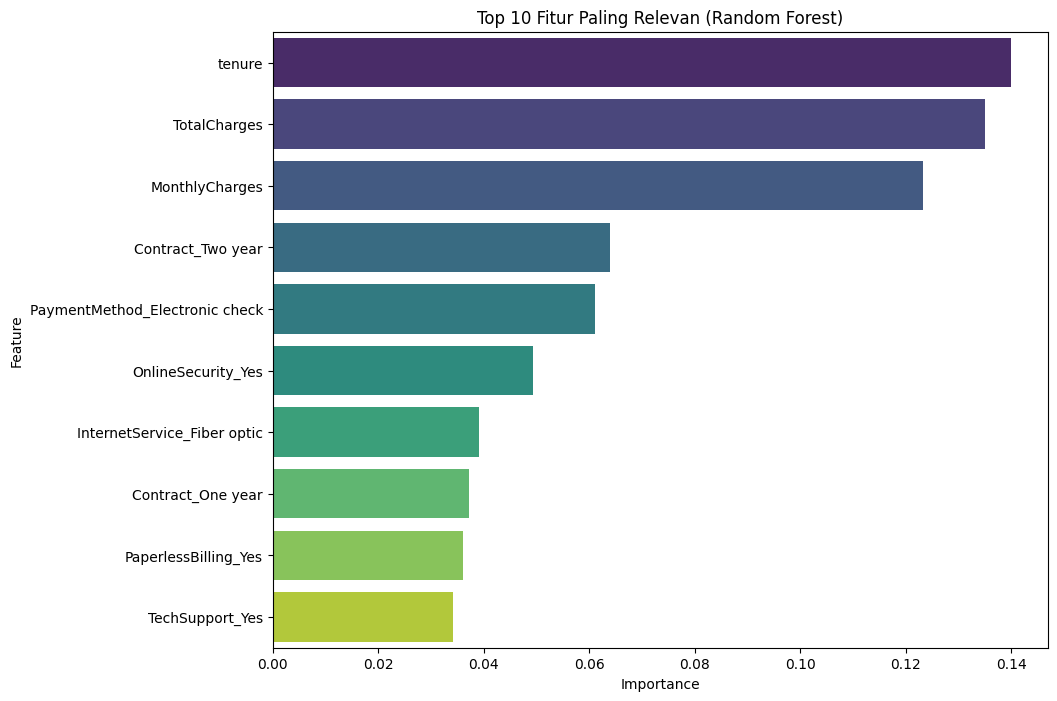

In [67]:
# Catatan: Voting Classifier tidak punya feature_importances langsung,
# kita gunakan model tunggal (RF atau LR) untuk ranking fitur.
print(f"--- Feature Importance (Berdasarkan {best_model_name}) ---")
if best_model_name == 'Random Forest':
    importances = models_direct['Random Forest'].feature_importances_
else:
    importances = np.abs(models_direct['Logistic Regression'].coef_[0])

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title(f'Top 10 Fitur Paling Relevan ({best_model_name})')
plt.show()

### 12. SIMPAN MODEL TERBAIK

In [68]:
filename_pkl = 'model_churn_terbaik.pkl'
with open(filename_pkl, 'wb') as file:
    # Menyimpan model terbaik dan preprocessor dalam satu file
    pickle.dump({'model': models_direct[best_model_name], 'preprocessor': preprocessor}, file)

print(f"✅ Model '{best_model_name}' dan Preprocessor berhasil disimpan sebagai: {filename_pkl}")

✅ Model 'Random Forest' dan Preprocessor berhasil disimpan sebagai: model_churn_terbaik.pkl
